In [1]:
import pandas as pd 
import torch 
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import models
from tqdm import tqdm
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import warnings
warnings.filterwarnings("ignore")

In [2]:
# artist data
artist_train = pd.read_csv('wikiart_csv/artist_train.csv', names=["path", "artist"])
artist_val = pd.read_csv('wikiart_csv/artist_val.csv', names=["path", "artist"])

# genre data
genre_train = pd.read_csv('wikiart_csv/genre_train.csv', names=["path", "genre"])
genre_val = pd.read_csv('wikiart_csv/genre_val.csv', names=["path", "genre"])

# style data
style_train = pd.read_csv('wikiart_csv/style_train.csv', names=["path", "style"])
style_val = pd.read_csv('wikiart_csv/style_val.csv', names=["path", "style"])

In [3]:
print(f'Number of artists in the training set: {len(artist_train["artist"].unique())}')
print(f'Number of artists in the validation set: {len(artist_val["artist"].unique())}')

print(f'Number of genres in the training set: {len(genre_train["genre"].unique())}')
print(f'Number of genres in the validation set: {len(genre_val["genre"].unique())}')

print(f'Number of styles in the training set: {len(style_train["style"].unique())}')
print(f'Number of styles in the validation set: {len(style_val["style"].unique())}')

Number of artists in the training set: 23
Number of artists in the validation set: 23
Number of genres in the training set: 10
Number of genres in the validation set: 10
Number of styles in the training set: 27
Number of styles in the validation set: 27


## In this section, I will be finding out the outliers. To find outliers, I will train a single class classification models and images with least confidence score will be considered as outliers

In [4]:
def z_score(df):
    images = []
    for i in range(len(df)):
        img = Image.open('wikiart/' + df.iloc[i, 0])
        img = transform(img)
        # img = img.unsqueeze(0)
        images.append(img.flatten())
    feature_tensors = torch.stack(images)
    # Compute mean and standard deviation for each feature
    feature_means = torch.mean(feature_tensors, dim=0)
    feature_stds = torch.std(feature_tensors, dim=0)

    # Compute z-scores for each feature
    z_scores = torch.abs((feature_tensors - feature_means) / feature_stds)

    # Compute z-score for each image (use maximum z-score across features)
    image_z_scores, _ = torch.max(z_scores, dim=1)
    df["z_score"] = image_z_scores.tolist()



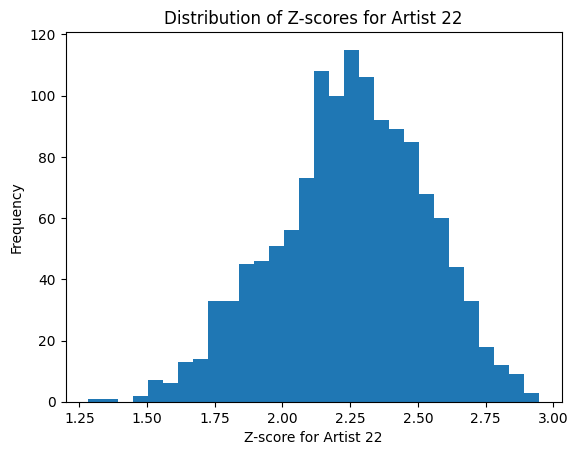

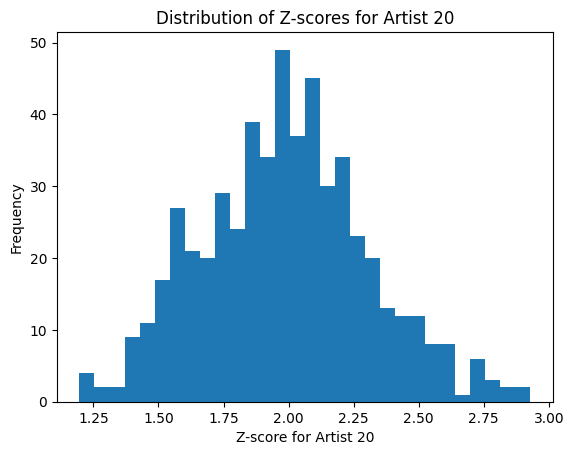

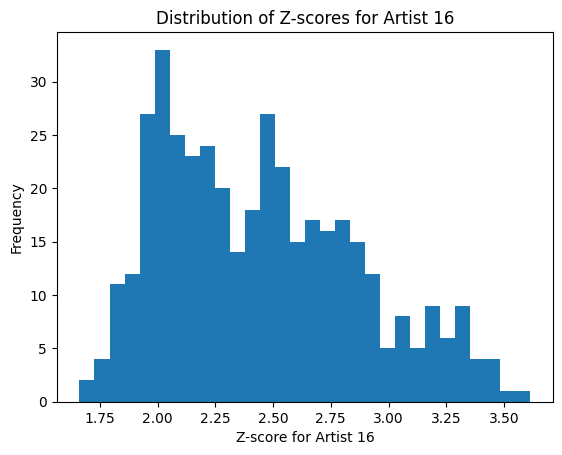

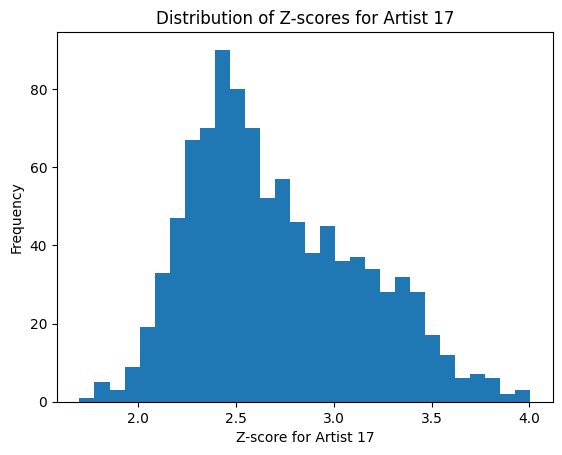

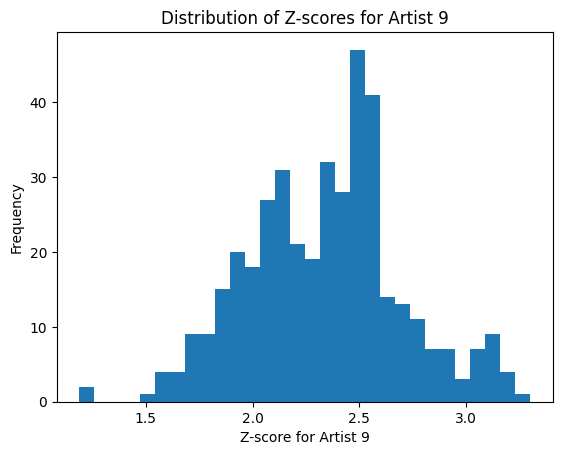

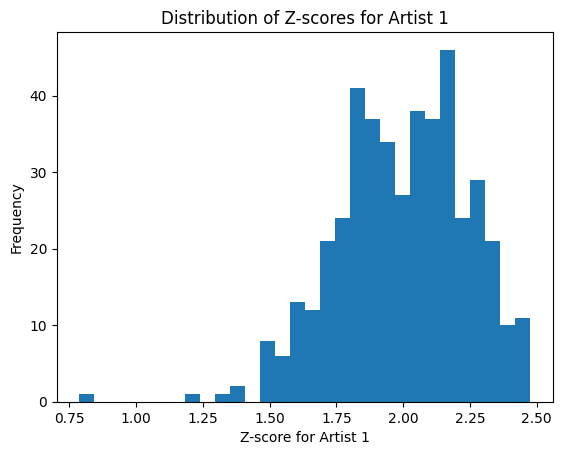

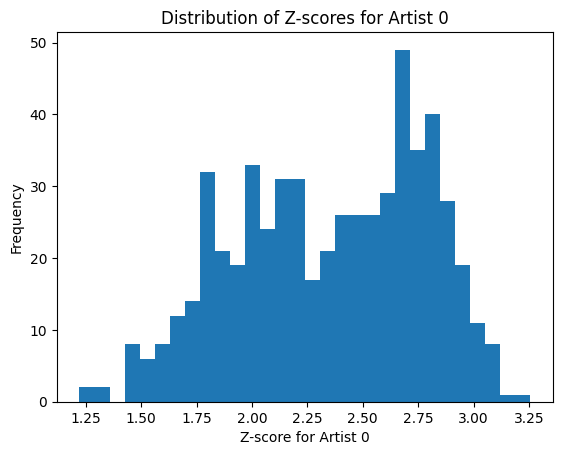

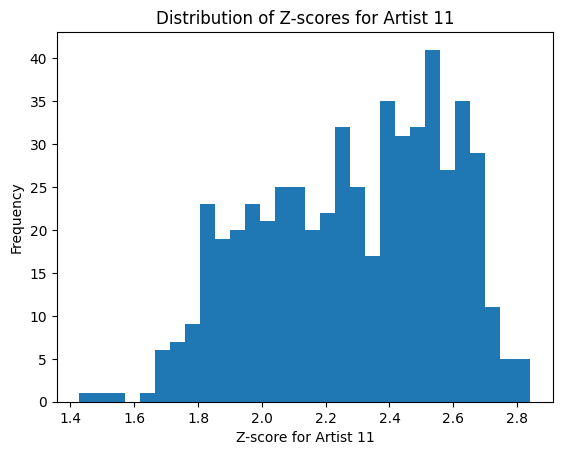

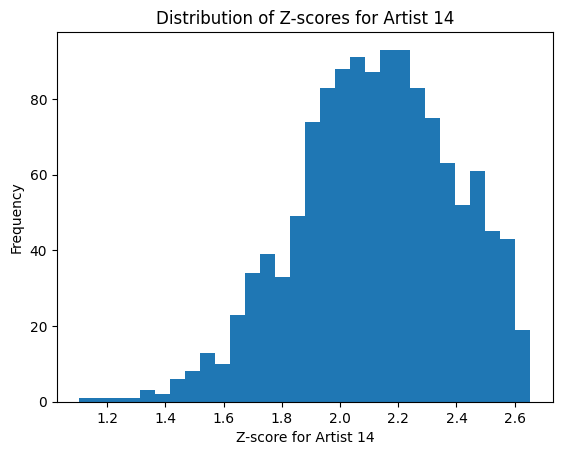

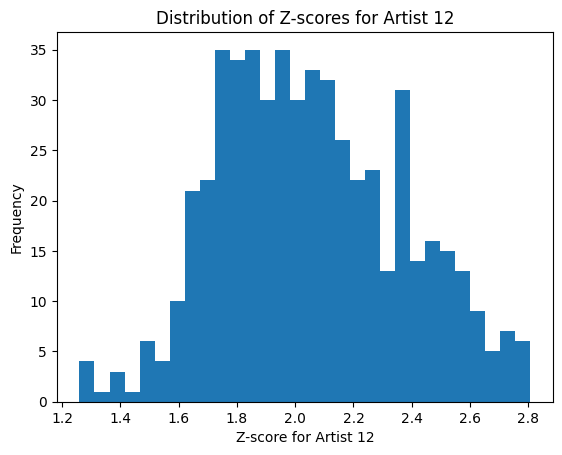

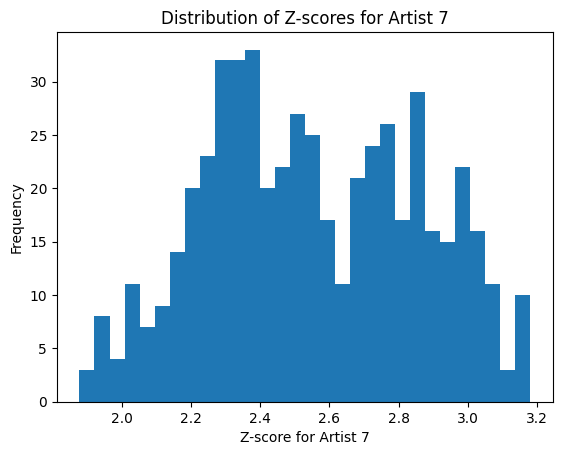

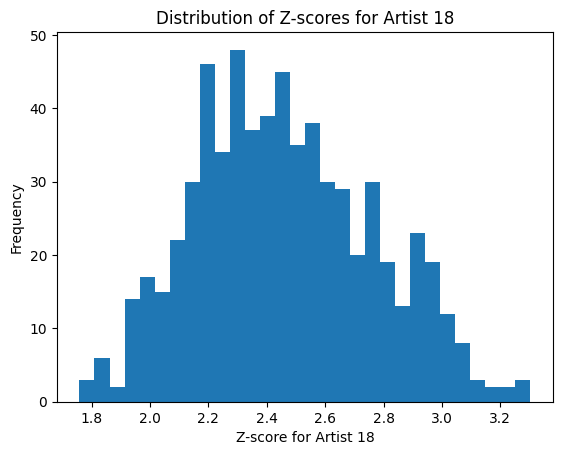

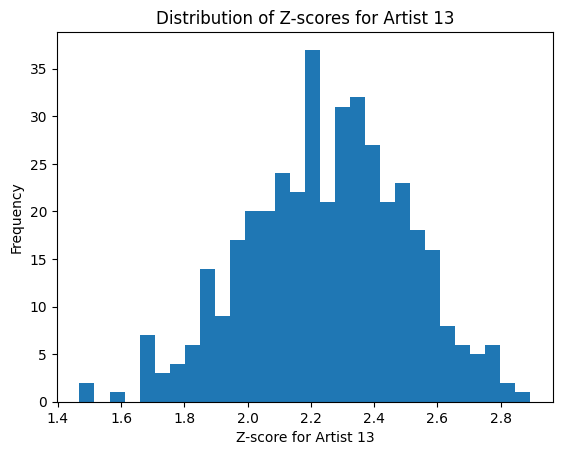

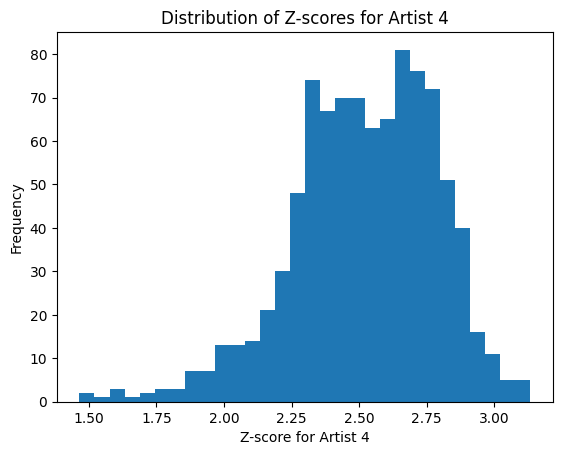

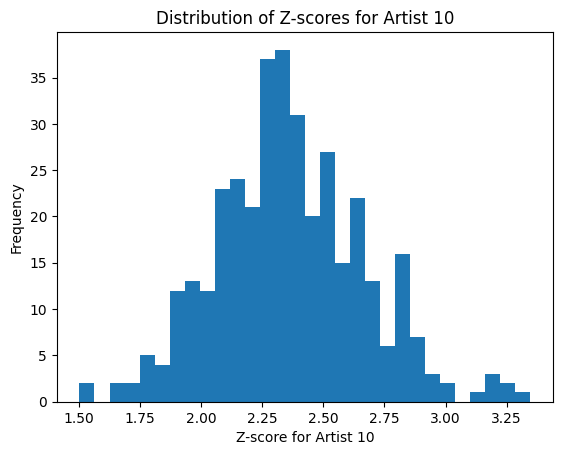

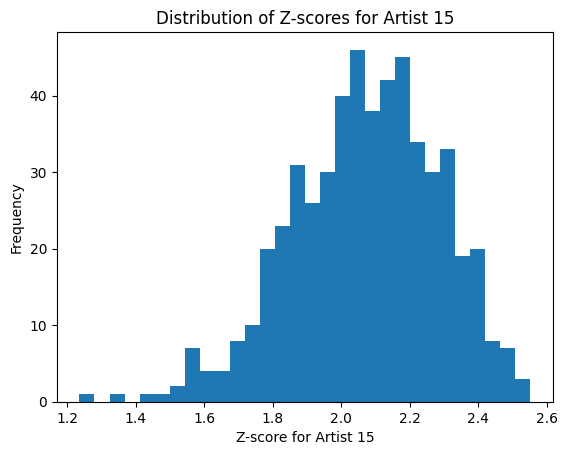

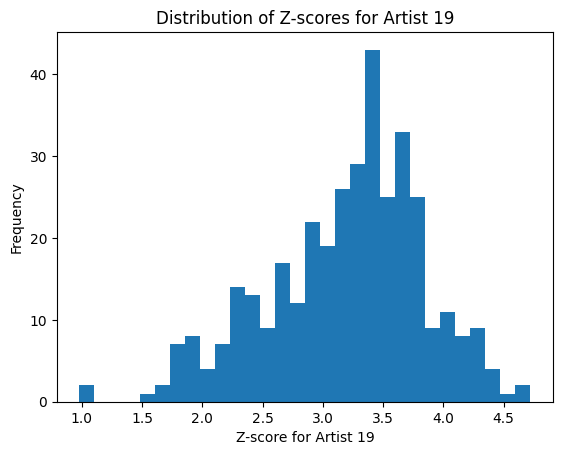

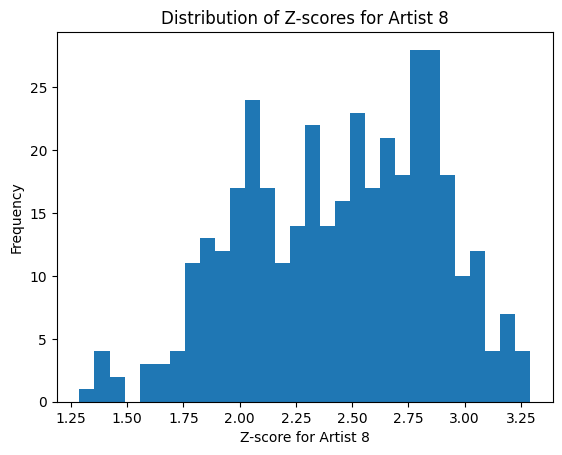

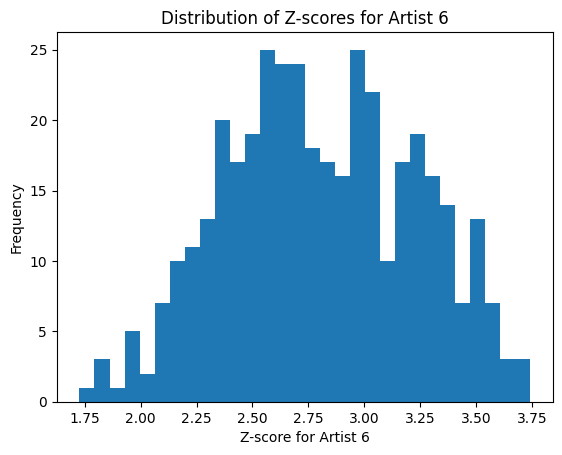

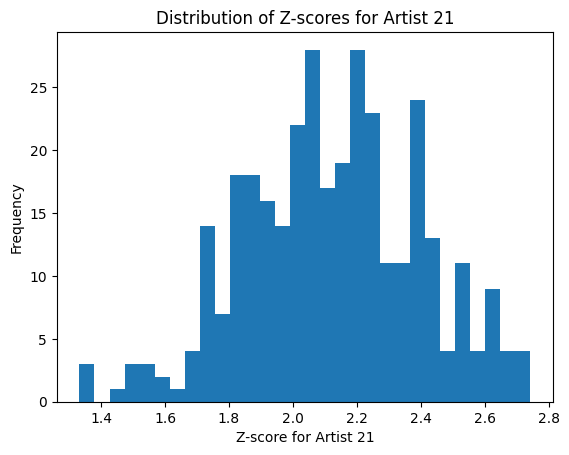

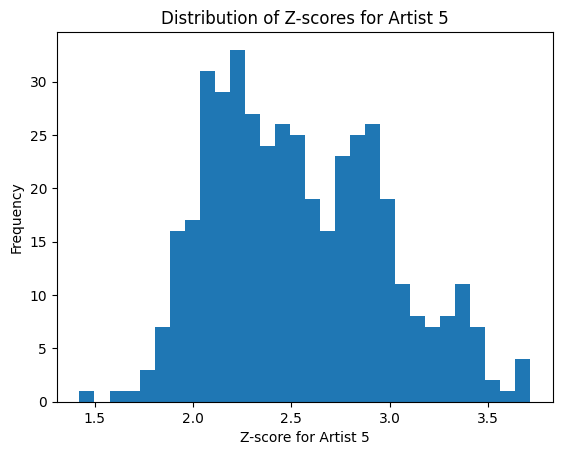

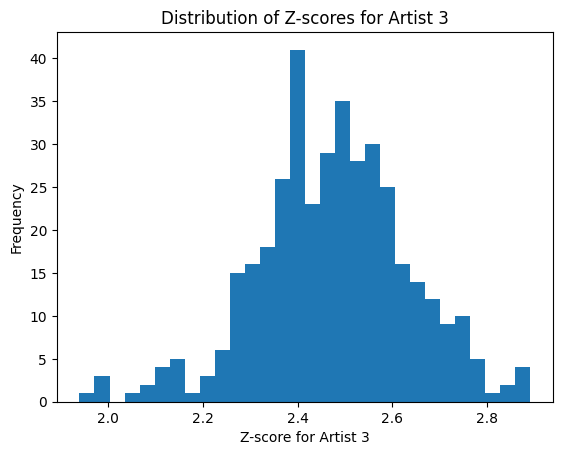

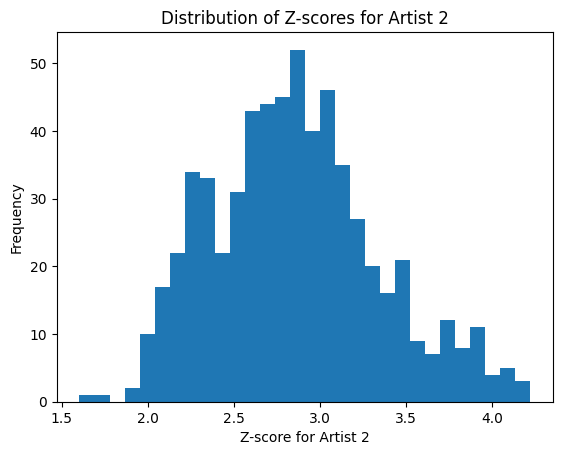

In [7]:
for artist in artist_train["artist"].unique():
    artist_df = artist_train[artist_train["artist"] == artist]
    z_score(artist_df)
    artist_train.loc[artist_train["artist"] == artist, "z_score"] = artist_df["z_score"]

    # show the distribution of z-scores
    plt.hist(artist_df["z_score"], bins=30)
    plt.xlabel("Z-score for Artist " + str(artist))
    plt.ylabel("Frequency")
    plt.title("Distribution of Z-scores for Artist " + str(artist))
    plt.show()

In [16]:
artist_train[artist_train["z_score"] > 3].shape

(1120, 3)

In [15]:
artist_train.shape

(13346, 3)

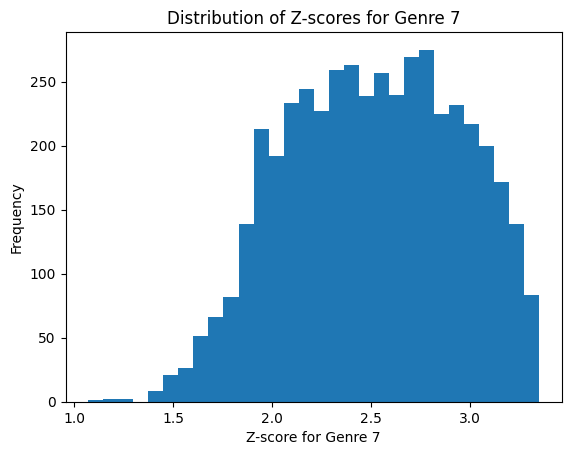

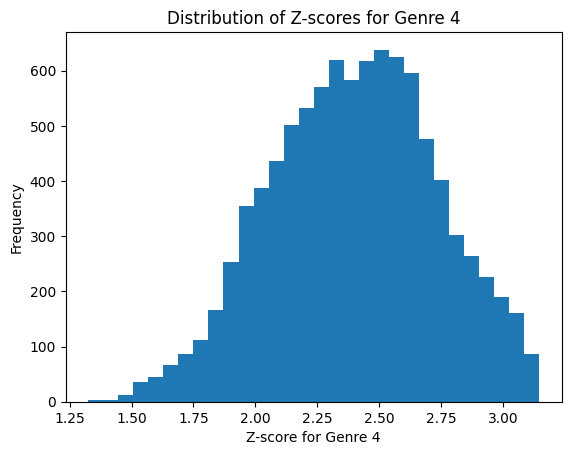

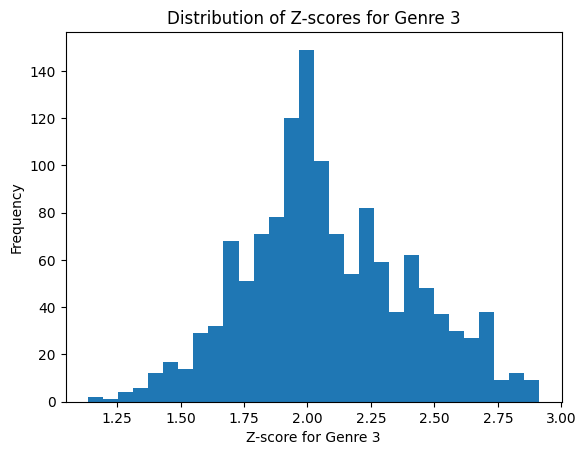

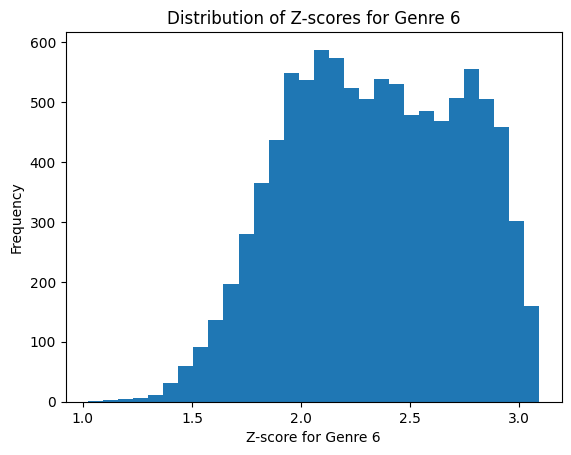

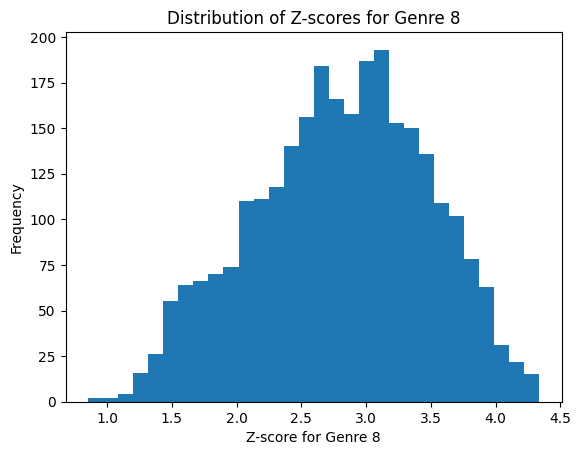

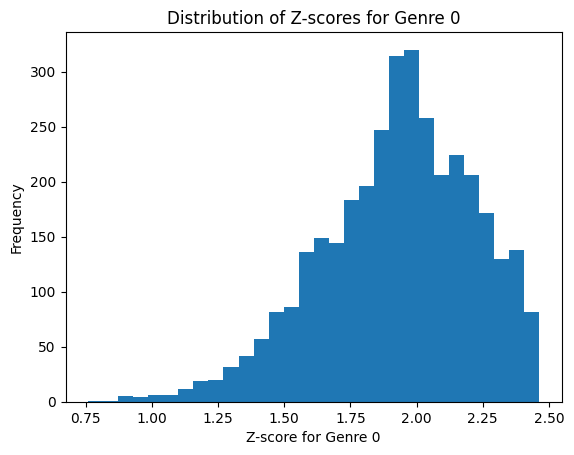

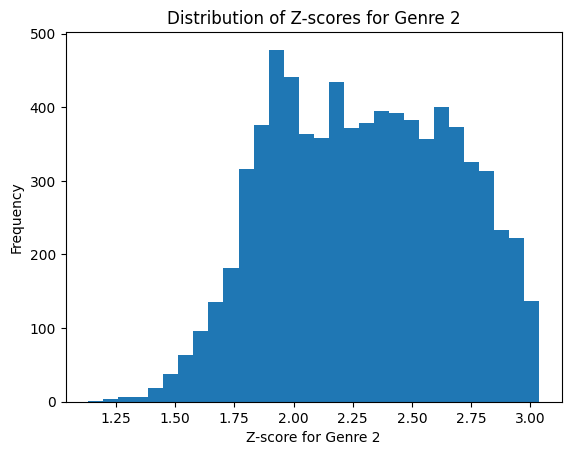

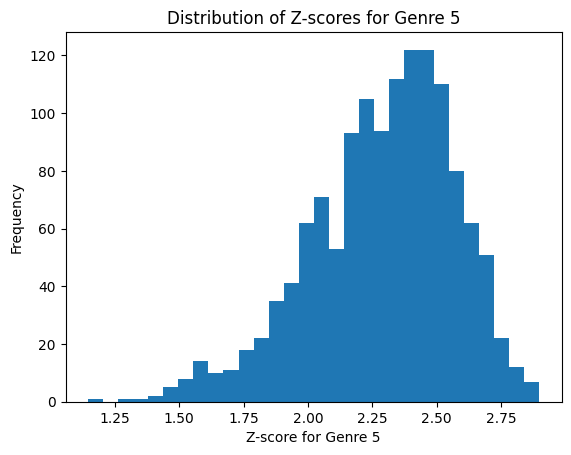

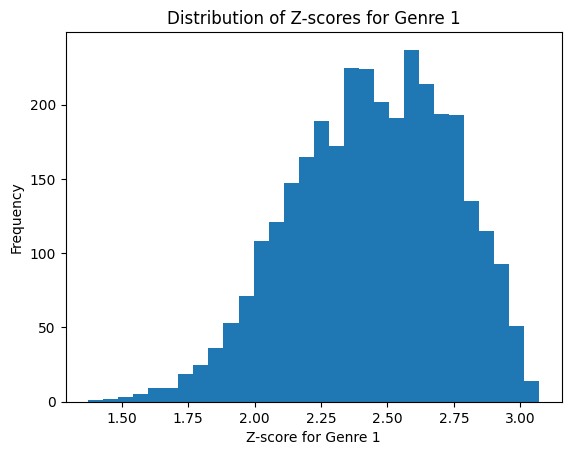

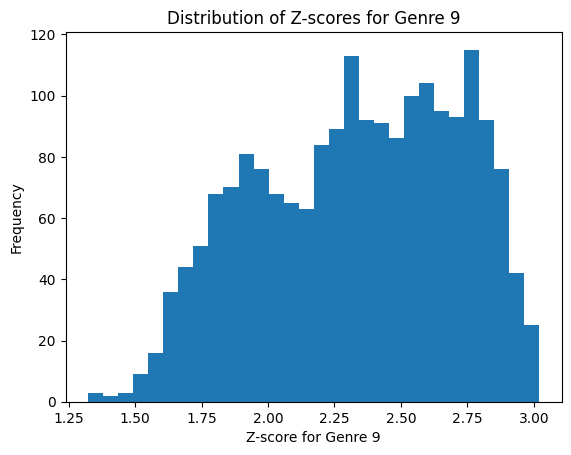

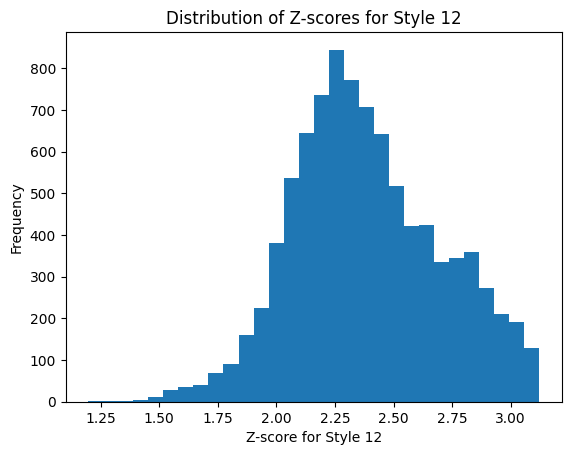

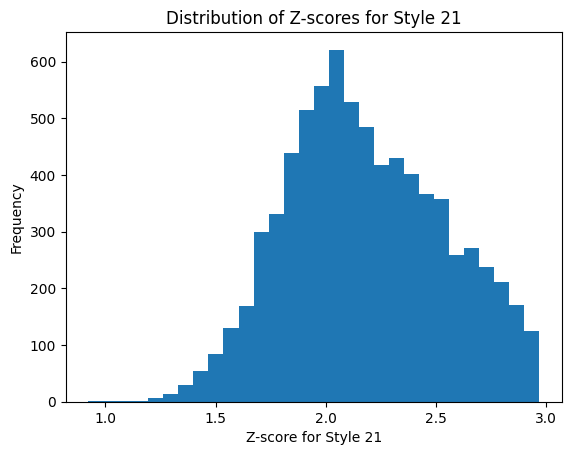

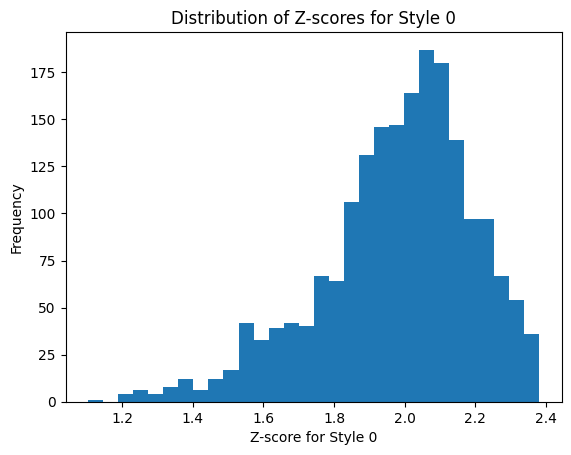

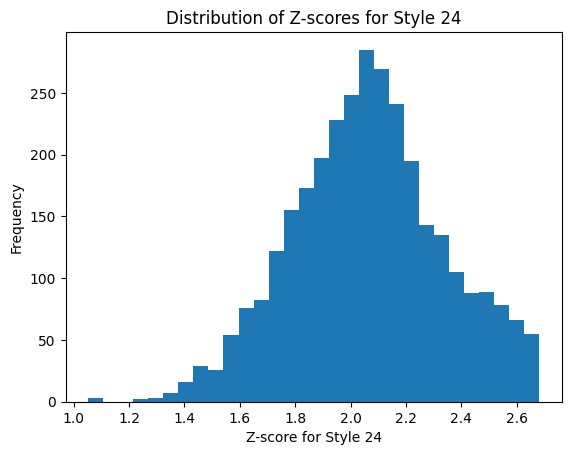

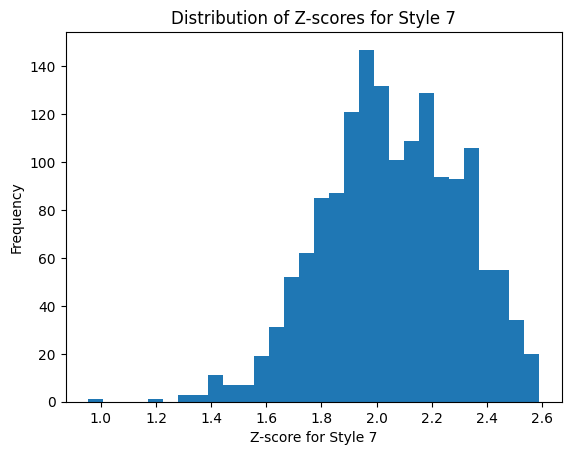

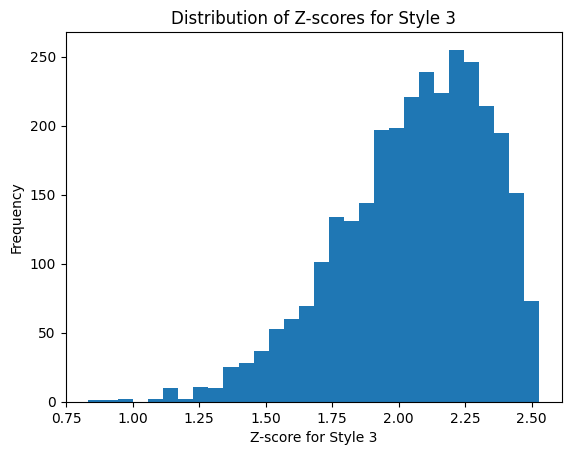

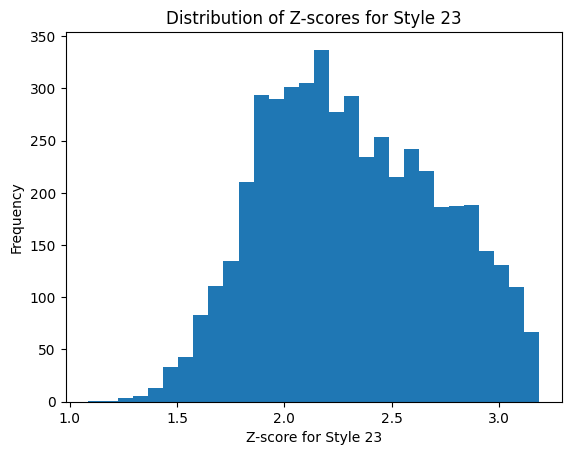

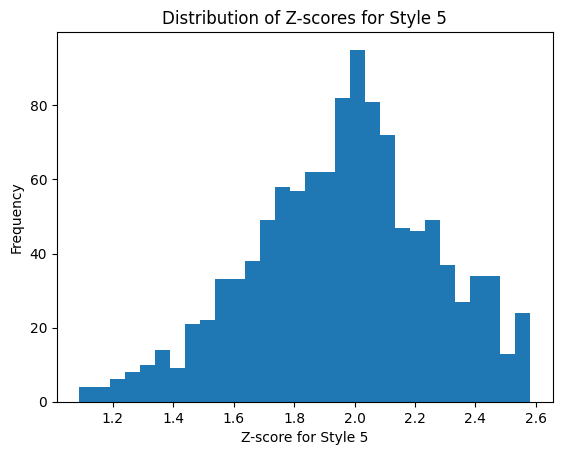

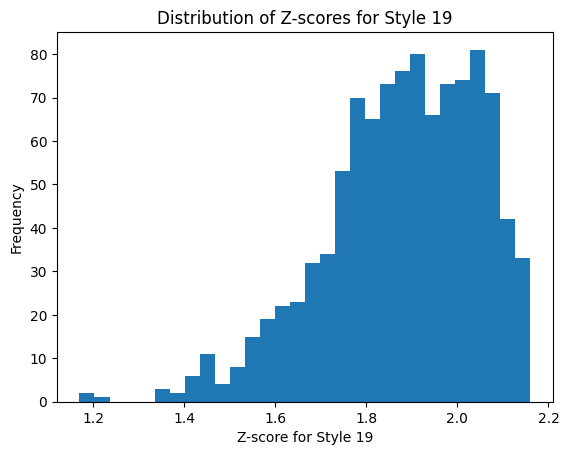

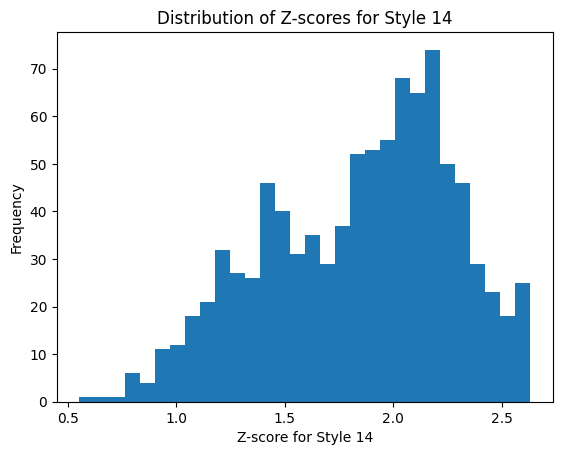

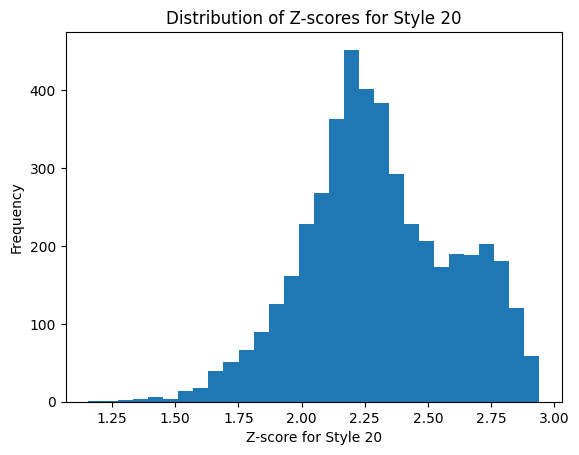

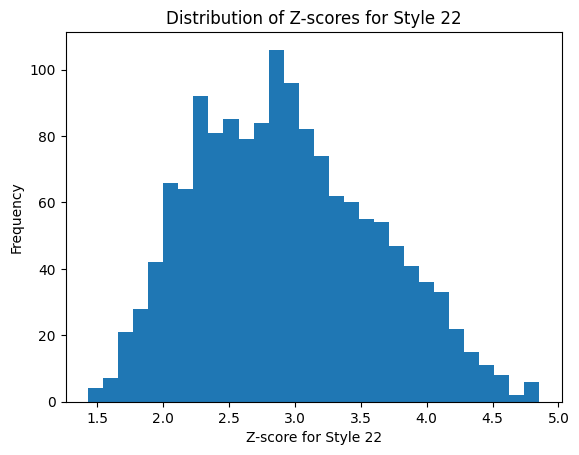

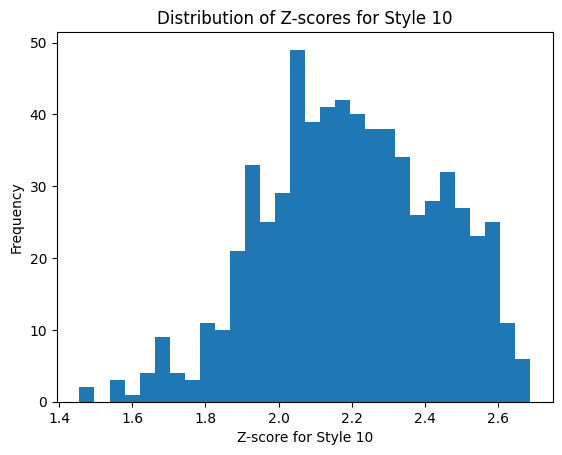

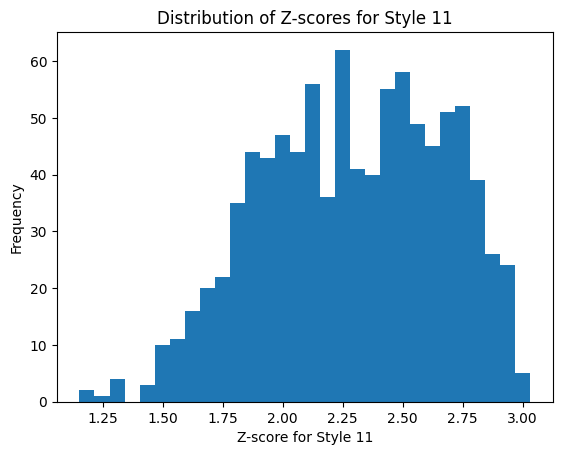

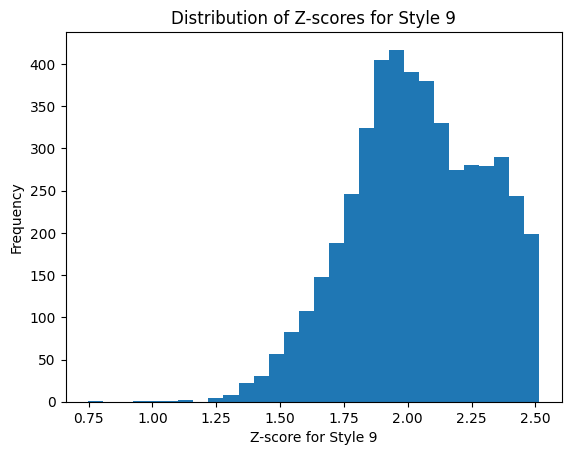

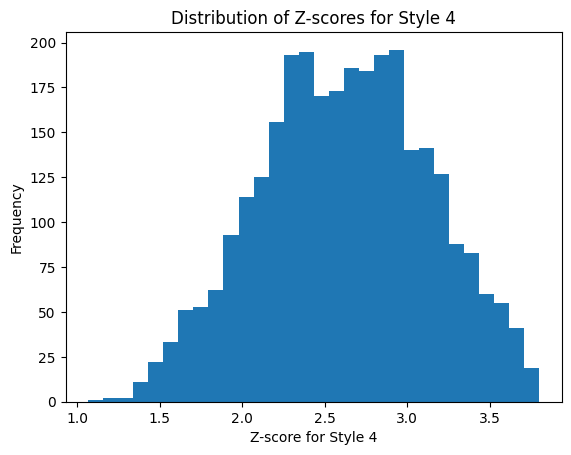

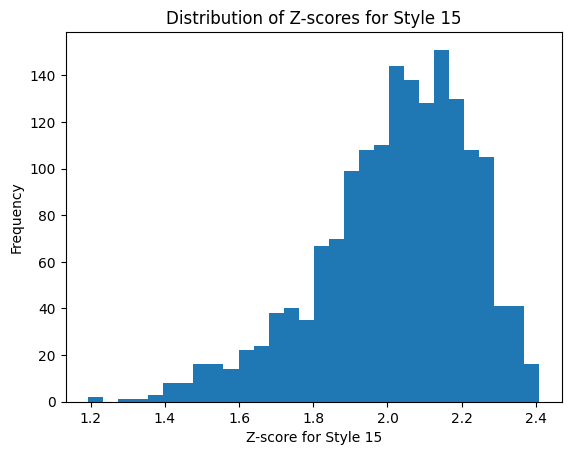

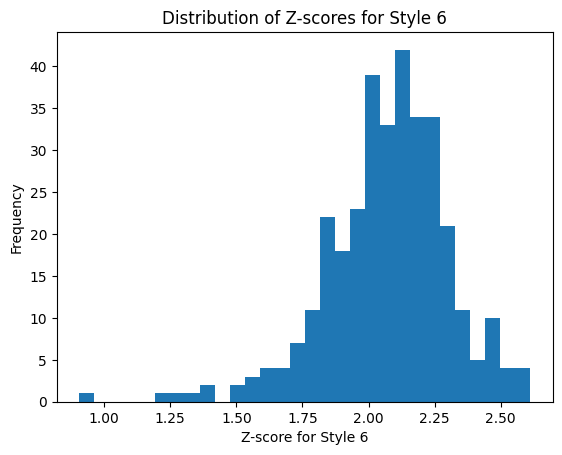

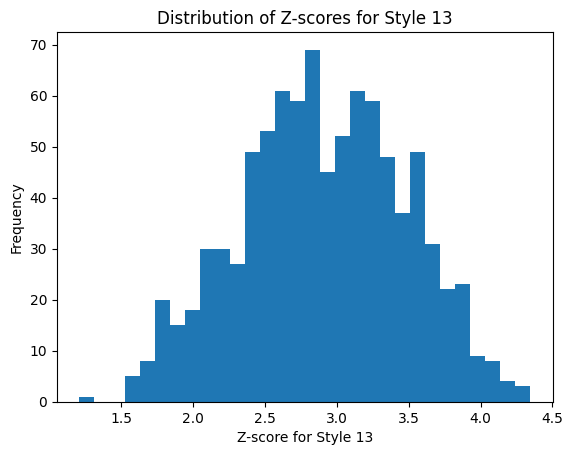

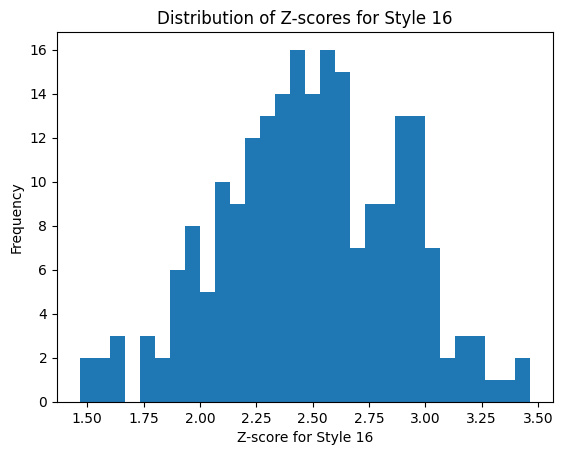

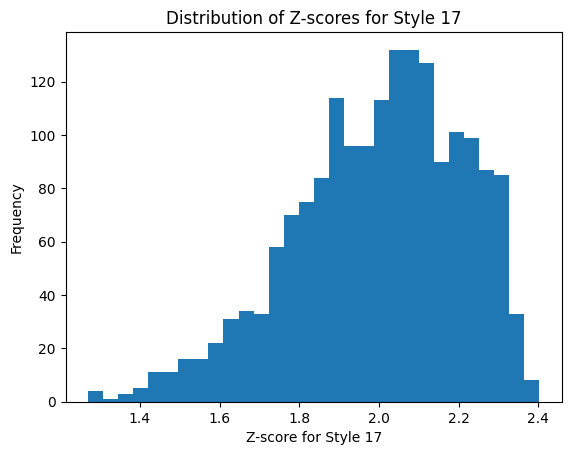

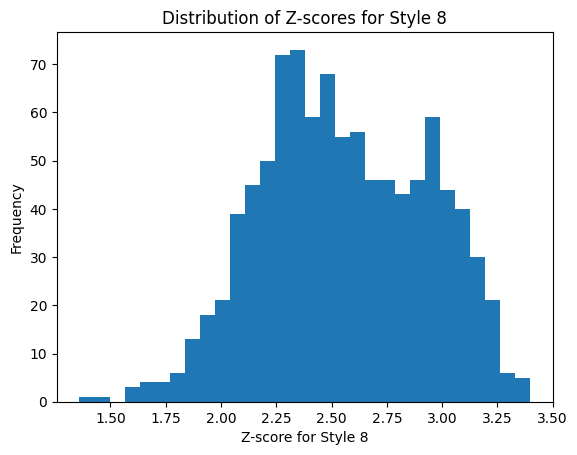

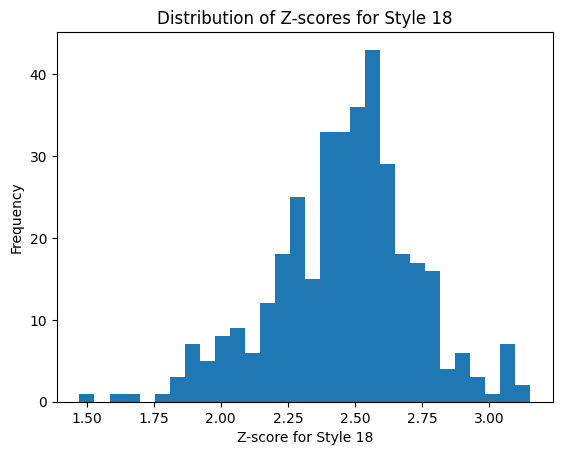

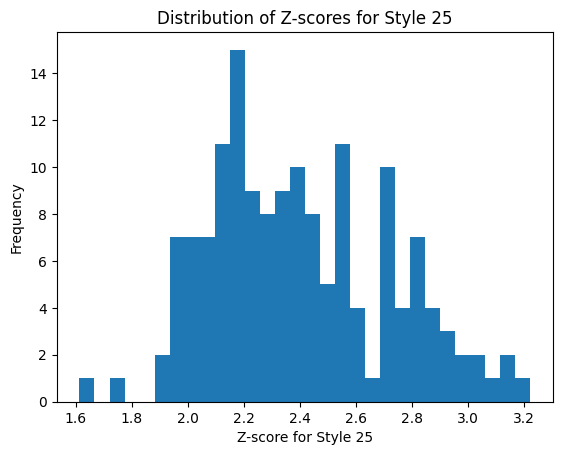

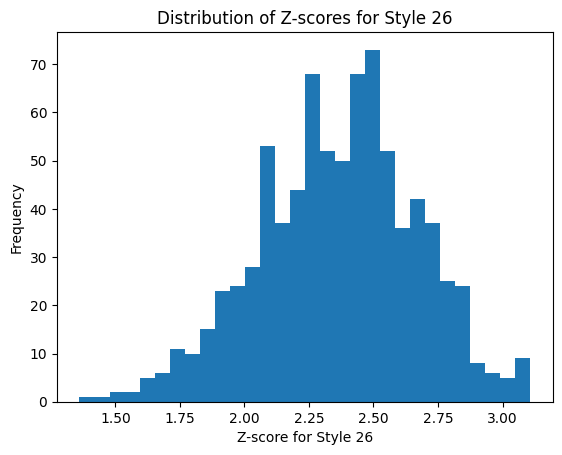

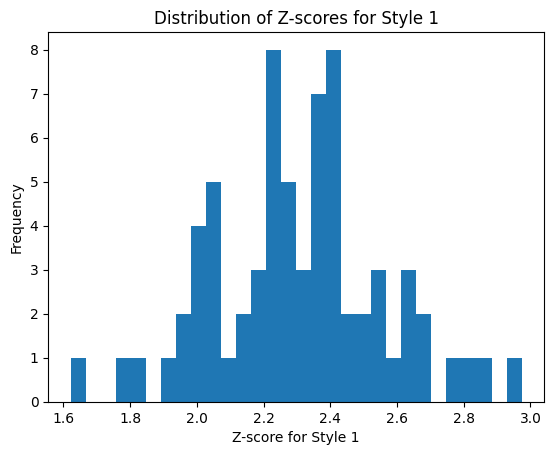

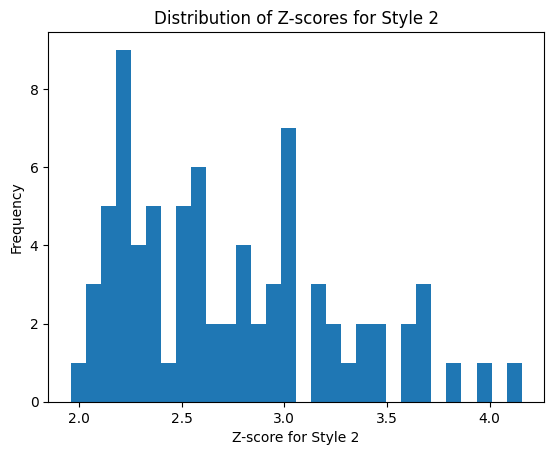

In [17]:
# create z score for genre
for genre in genre_train["genre"].unique():
    genre_df = genre_train[genre_train["genre"] == genre]
    z_score(genre_df)
    genre_train.loc[genre_train["genre"] == genre, "z_score"] = genre_df["z_score"]

    # show the distribution of z-scores
    plt.hist(genre_df["z_score"], bins=30)
    plt.xlabel("Z-score for Genre " + str(genre))
    plt.ylabel("Frequency")
    plt.title("Distribution of Z-scores for Genre " + str(genre))
    plt.show()

# create z score for style
for style in style_train["style"].unique():
    style_df = style_train[style_train["style"] == style]
    z_score(style_df)
    style_train.loc[style_train["style"] == style, "z_score"] = style_df["z_score"]

    # show the distribution of z-scores
    plt.hist(style_df["z_score"], bins=30)
    plt.xlabel("Z-score for Style " + str(style))
    plt.ylabel("Frequency")
    plt.title("Distribution of Z-scores for Style " + str(style))
    plt.show()

In [18]:
artist_train.to_csv("wikiart_csv/artist_train_z.csv", index=False)
genre_train.to_csv("wikiart_csv/genre_train_z.csv", index=False)
style_train.to_csv("wikiart_csv/style_train_z.csv", index=False)

In [4]:
artist_train = pd.read_csv("wikiart_csv/artist_train_z.csv")
genre_train = pd.read_csv("wikiart_csv/genre_train_z.csv")
style_train = pd.read_csv("wikiart_csv/style_train_z.csv")


In [5]:
print(f"Length of artist train before removing outliers: {artist_train.shape[0]}")
print(f"Length of genre train before removing outliers: {genre_train.shape[0]}")
print(f"Length of style train before removing outliers: {style_train.shape[0]}")
artist_train = artist_train[artist_train["z_score"] < 3]
genre_train = genre_train[genre_train["z_score"] < 3]
style_train = style_train[style_train["z_score"] < 3]
print(f"Length of artist train after removing outliers: {artist_train.shape[0]}")
print(f"Length of genre train after removing outliers: {genre_train.shape[0]}")
print(f"Length of style train after removing outliers: {style_train.shape[0]}")

Length of artist train before removing outliers: 13346
Length of genre train before removing outliers: 45503
Length of style train before removing outliers: 57025
Length of artist train after removing outliers: 12226
Length of genre train after removing outliers: 42957
Length of style train after removing outliers: 54501


In [6]:
print(f"Number of styles in the training set after removing outliers: {len(style_train['style'].unique())}")
print(f"Number of genres in the training set after removing outliers: {len(genre_train['genre'].unique())}")

Number of styles in the training set after removing outliers: 27
Number of genres in the training set after removing outliers: 10


In [7]:
# make random split for genre and style to make the length same as artist while keeping the distribution
genre_train = genre_train.sample(n=artist_train.shape[0], random_state=42)
style_train = style_train.sample(n=artist_train.shape[0], random_state=42)

genre_val = genre_val.sample(n=artist_val.shape[0], random_state=42)
style_val = style_val.sample(n=artist_val.shape[0], random_state=42)

print(f"Length of artist train after random split: {artist_train.shape[0]}")
print(f"Length of genre train after random split: {genre_train.shape[0]}")
print(f"Length of style train after random split: {style_train.shape[0]}")
print(f"Length of artist val after random split: {artist_val.shape[0]}")
print(f"Length of genre val after random split: {genre_val.shape[0]}")
print(f"Length of style val after random split: {style_val.shape[0]}")

print(f"Number of styles in the training set after random split: {len(style_train['style'].unique())}")
print(f"Number of genres in the training set after random split: {len(genre_train['genre'].unique())}")
print(f"Number of styles in the validation set after random split: {len(style_val['style'].unique())}")
print(f"Number of genres in the validation set after random split: {len(genre_val['genre'].unique())}")


Length of artist train after random split: 12226
Length of genre train after random split: 12226
Length of style train after random split: 12226
Length of artist val after random split: 5706
Length of genre val after random split: 5706
Length of style val after random split: 5706
Number of styles in the training set after random split: 27
Number of genres in the training set after random split: 10
Number of styles in the validation set after random split: 27
Number of genres in the validation set after random split: 10


In [8]:
class SingleTaskDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_name = self.df.iloc[idx, 0]
        image = Image.open('wikiart/' + img_name)
        label = self.df.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        return image, label
    


class MultiTaskDataset(Dataset):
    def __init__(self, artist_dataset, style_dataset, genre_dataset, transform=None):
        self.artist_dataset = artist_dataset
        self.style_dataset = style_dataset
        self.genre_dataset = genre_dataset
        self.transform = transform

    def __len__(self):
        return len(self.artist_dataset)  

    def __getitem__(self, idx):
        artist_img, artist_label = self.artist_dataset[idx]
        style_img, style_label = self.style_dataset[idx]
        genre_img, genre_label = self.genre_dataset[idx]

        if self.transform:
            artist_img = self.transform(artist_img)
            style_img = self.transform(style_img)
            genre_img = self.transform(genre_img)

        return artist_img, style_img, genre_img, artist_label, style_label, genre_label

In [9]:
train_transform = transforms.Compose([
            transforms.RandomRotation(360),
            transforms.RandomHorizontalFlip(),
            transforms.RandomAffine(degrees=(-10, 10), translate=(0.05, 0.05), scale=(0.95, 1.05), shear=5),
            transforms.RandomPerspective(distortion_scale=0.1, p=0.1),  
            transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 0.2)),
            # transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
            # transforms.RandAugment(),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])

test_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

In [10]:
artist_train_dataset = SingleTaskDataset(artist_train)
style_train_dataset = SingleTaskDataset(style_train)
genre_train_dataset = SingleTaskDataset(genre_train)

artist_val_dataset = SingleTaskDataset(artist_val)
style_val_dataset = SingleTaskDataset(style_val)
genre_val_dataset = SingleTaskDataset(genre_val)

multi_task_dataset_train = MultiTaskDataset(artist_train_dataset, style_train_dataset, genre_train_dataset, train_transform)
multi_task_dataset_test = MultiTaskDataset(artist_val_dataset, style_val_dataset, genre_val_dataset, test_transform)

multi_task_dataloader_train = DataLoader(multi_task_dataset_train, batch_size=16, shuffle=True, num_workers=8)
multi_task_dataloader_test = DataLoader(multi_task_dataset_test, batch_size=128, shuffle=False, num_workers=8)

In [30]:
from model import CNN_RNN_Model

model = CNN_RNN_Model(num_classes_style=27, num_classes_artist=23, num_classes_genre=10, cnn_hidden_size=512, rnn_hidden_size=512)
model.load_state_dict(torch.load("runs/Best Model/best_model.pth"))
model.to(device)
model.eval()
corrects_style = 0
corrects_artist = 0
corrects_genre = 0
total = 0

# evaluate the model on the test set
for batch_idx, data in enumerate(multi_task_dataloader_test):
    artist_images, style_images, genre_images, artist_gt, style_gt, genre_gt = data
    artist_images = artist_images.to(device)
    style_images = style_images.to(device)
    genre_images = genre_images.to(device)
    artist_gt = torch.nn.functional.one_hot(artist_gt, num_classes=23).float().to(device)
    style_gt = torch.nn.functional.one_hot(style_gt, num_classes=27).float().to(device)
    genre_gt = torch.nn.functional.one_hot(genre_gt, num_classes=10).float().to(device)

    with torch.no_grad():
        # Forward pass
        _, artist_pred, _ = model(artist_images)
        style_pred, _, _ = model(style_images)
        _, _, genre_pred = model(genre_images)

        # check accuracy
        style_pred = torch.round(style_pred)
        artist_pred = torch.round(artist_pred)
        genre_pred = torch.round(genre_pred)
        corrects_style += (torch.argmax(style_gt, dim=1) == torch.argmax(style_pred.sigmoid(), dim=1)).sum().item()
        corrects_artist += (torch.argmax(artist_gt, dim=1) == torch.argmax(artist_pred.sigmoid(), dim=1)).sum().item()
        corrects_genre += (torch.argmax(genre_gt, dim=1) == torch.argmax(genre_pred.sigmoid(), dim=1)).sum().item()
        total += len(style_gt)

print(f"Artist accuracy: {corrects_artist / total}")
print(f"Genre accuracy: {corrects_genre / total}")
print(f"Style accuracy: {corrects_style / total}")

Artist accuracy: 0.7867157378198387
Genre accuracy: 0.5571328426218016
Style accuracy: 0.3617245005257624


In [11]:
class MultiTaskModel(nn.Module):
    def __init__(self, num_classes_style, num_classes_artist, num_classes_genre, cnn_hidden_size, rnn_hidden_size):
        super(MultiTaskModel, self).__init__()
        self.cnn = models.resnet50(pretrained=True)  
        in_features = self.cnn.fc.in_features
        self.cnn.fc = nn.Linear(in_features, cnn_hidden_size)

        self.rnn = nn.LSTM(input_size=cnn_hidden_size, hidden_size=rnn_hidden_size, num_layers=1, batch_first=True)

        self.fc_style = nn.Linear(rnn_hidden_size, num_classes_style)
        self.fc_artist = nn.Linear(rnn_hidden_size, num_classes_artist)
        self.fc_genre = nn.Linear(rnn_hidden_size, num_classes_genre)

    def forward(self, x, task="all"):
        cnn_features = self.cnn(x)
        rnn_output, _ = self.rnn(cnn_features)

        # Classification for style, artist, and genre
        if task == "style" or task == "all":
            output_style = self.fc_style(rnn_output)
            if task == "style":
                return output_style
            
        elif task == "artist" or task == "all":
            output_artist = self.fc_artist(rnn_output)
            if task == "artist":
                return output_artist
             
        elif task == "genre" or task == "all":
            output_genre = self.fc_genre(rnn_output)
            if task == "genre":
                return output_genre

        return output_style, output_artist, output_genre

    @property
    def device(self):
        return next(self.parameters()).device

In [12]:
def train_one_epoch(model, train_loader, optimizer, loss_fn, iteration, summary_writer, device):
    model.train()
    losses = 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader))
    for batch_idx, data in progress_bar:
        artist_images, style_images, genre_images, artist_gt, style_gt, genre_gt = data
        artist_images = artist_images.to(device)
        style_images = style_images.to(device)
        genre_images = genre_images.to(device)
        artist_gt = torch.nn.functional.one_hot(artist_gt, num_classes=23).float().to(device)
        style_gt = torch.nn.functional.one_hot(style_gt, num_classes=27).float().to(device)
        genre_gt = torch.nn.functional.one_hot(genre_gt, num_classes=10).float().to(device)

        optimizer.zero_grad()
        
        # Forward pass
        artist_pred = model(artist_images, task="artist")
        style_pred = model(style_images, task="style")
        genre_pred = model(genre_images, task="genre")
        
        # Compute loss
        loss_style = loss_fn(style_pred, style_gt.to(device))
        loss_artist = loss_fn(artist_pred, artist_gt.to(device))
        loss_genre = loss_fn(genre_pred, genre_gt.to(device))
        loss = loss_style + loss_artist + loss_genre
        summary_writer.add_scalar("Loss/train", loss.item(), iteration)
        summary_writer.add_scalar("Style Loss/train", loss_style.item(), iteration)
        summary_writer.add_scalar("Artist Loss/train", loss_artist.item(), iteration)
        summary_writer.add_scalar("Genre Loss/train", loss_genre.item(), iteration)
        iteration += 1
        losses += loss.item()
        loss.backward()
        optimizer.step()
        
        # progress_bar.set_description(f"Loss: {losses / len(train_loader)}")
        
    return losses / len(train_loader), model, iteration

In [13]:
def evaluate(model, val_loader, loss_fn, device):
    model.eval()
    losses = 0
    corrects_style = 0
    corrects_artist = 0
    corrects_genre = 0
    
    progress_bar = tqdm(enumerate(val_loader), total=len(val_loader))
    for batch_idx, data in progress_bar:
        artist_images, style_images, genre_images, artist_gt, style_gt, genre_gt = data
        artist_images = artist_images.to(device)
        style_images = style_images.to(device)
        genre_images = genre_images.to(device)
        artist_gt = torch.nn.functional.one_hot(artist_gt, num_classes=23).float().to(device)
        style_gt = torch.nn.functional.one_hot(style_gt, num_classes=27).float().to(device)
        genre_gt = torch.nn.functional.one_hot(genre_gt, num_classes=10).float().to(device)

        with torch.no_grad():
           # Forward pass
            artist_pred = model(artist_images, task="artist")
            style_pred = model(style_images, task="style")
            genre_pred = model(genre_images, task="genre")
            
            # Compute loss
            loss_style = loss_fn(style_pred, style_gt)
            loss_artist = loss_fn(artist_pred, artist_gt)
            loss_genre = loss_fn(genre_pred, genre_gt)
            loss = loss_style + loss_artist + loss_genre
            # check accuracy
            style_pred = torch.round(style_pred)
            artist_pred = torch.round(artist_pred)
            genre_pred = torch.round(genre_pred)
            corrects_style += (torch.argmax(style_gt, dim=1) == torch.argmax(style_pred.sigmoid(), dim=1)).sum().item()
            corrects_artist += (torch.argmax(artist_gt, dim=1) == torch.argmax(artist_pred.sigmoid(), dim=1)).sum().item()
            corrects_genre += (torch.argmax(genre_gt, dim=1) == torch.argmax(genre_pred.sigmoid(), dim=1)).sum().item()
            losses += loss.item()
            
            # progress_bar.set_description(f"Loss: {losses /len(val_loader)} Style: {corrects_style / len(val_loader.dataset)} "
                                #  f"Artist: {corrects_artist / len(val_loader.dataset)} Genre: {corrects_genre / len(val_loader.dataset)}")

    return (losses / len(val_loader), corrects_artist / len(val_loader.dataset),
            corrects_genre / len(val_loader.dataset), corrects_style / len(val_loader.dataset), model)

In [14]:
from torch.utils.tensorboard import SummaryWriter
import os

epochs = 10
best_acc = -float("inf")
summary_writer = SummaryWriter()
iteration = 0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultiTaskModel(num_classes_style=27, num_classes_artist=23, num_classes_genre=10, cnn_hidden_size=512, rnn_hidden_size=256).to(device)
if os.path.exists("best_model.pth"):
    model.load_state_dict(torch.load("best_model.pth"))
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss().to(device)

for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        train_loss, model, iteration = train_one_epoch(model, multi_task_dataloader_train, optimizer, loss_fn, iteration, summary_writer, device)
        print(f"Train loss: {train_loss}")
        if epoch % 5 == 0:
            val_loss, artist_acc, genre_acc, style_acc, model = evaluate(model, multi_task_dataloader_test, loss_fn, device)
            print(f"Val loss: {val_loss}")
            print(f"Artist accuracy: {artist_acc}")
            print(f"Genre accuracy: {genre_acc}")
            print(f"Style accuracy: {style_acc}")
            val_acc = artist_acc + genre_acc + style_acc

            summary_writer.add_scalar("Accuracy/Artist val", artist_acc, epoch)
            summary_writer.add_scalar("Accuracy/Genre val", genre_acc, epoch)
            summary_writer.add_scalar("Accuracy/Style val", style_acc, epoch)
            summary_writer.add_scalar("Accuracy/Total val", val_acc, epoch)
            summary_writer.add_scalar("Loss/val", val_loss, epoch)
            if val_acc > best_acc:
                best_acc = val_acc
                torch.save(model.state_dict(), "best_model.pth")
                print("Saved best model")

Epoch 1/10


100%|██████████| 765/765 [19:20<00:00,  1.52s/it]

Train loss: 4.39055715105892



100%|██████████| 45/45 [03:53<00:00,  5.19s/it]


Val loss: 4.9995278623369
Artist accuracy: 0.5215562565720294
Genre accuracy: 0.5283911671924291
Style accuracy: 0.33175604626708727
Saved best model
Epoch 2/10


100%|██████████| 765/765 [17:20<00:00,  1.36s/it]

Train loss: 4.411601021398906
Epoch 3/10



100%|██████████| 765/765 [18:33<00:00,  1.46s/it]

Train loss: 4.341431532342449
Epoch 4/10



100%|██████████| 765/765 [16:27<00:00,  1.29s/it]

Train loss: 4.338807196398966
Epoch 5/10



100%|██████████| 765/765 [16:38<00:00,  1.31s/it]

Train loss: 4.235402476242165
Epoch 6/10



100%|██████████| 765/765 [16:33<00:00,  1.30s/it]

Train loss: 4.207161811442157



100%|██████████| 45/45 [00:54<00:00,  1.21s/it]


Val loss: 4.579151503245035
Artist accuracy: 0.5899053627760252
Genre accuracy: 0.570627409744129
Style accuracy: 0.36820890290921837
Saved best model
Epoch 7/10


100%|██████████| 765/765 [16:34<00:00,  1.30s/it] 

Train loss: 4.159873819974512
Epoch 8/10



100%|██████████| 765/765 [17:02<00:00,  1.34s/it]

Train loss: 4.131846572215261
Epoch 9/10



100%|██████████| 765/765 [18:13<00:00,  1.43s/it]

Train loss: 4.166387606913747
Epoch 10/10



100%|██████████| 765/765 [17:31<00:00,  1.37s/it]  

Train loss: 4.143882445104761


In [15]:
for epoch in range(30):
        print(f"Epoch {epoch+1}/{epochs}")
        train_loss, model, iteration = train_one_epoch(model, multi_task_dataloader_train, optimizer, loss_fn, iteration, summary_writer, device)
        print(f"Train loss: {train_loss}")
        if epoch % 5 == 0:
            val_loss, artist_acc, genre_acc, style_acc, model = evaluate(model, multi_task_dataloader_test, loss_fn, device)
            print(f"Val loss: {val_loss}")
            print(f"Artist accuracy: {artist_acc}")
            print(f"Genre accuracy: {genre_acc}")
            print(f"Style accuracy: {style_acc}")
            val_acc = artist_acc + genre_acc + style_acc

            summary_writer.add_scalar("Accuracy/Artist val", artist_acc, epoch)
            summary_writer.add_scalar("Accuracy/Genre val", genre_acc, epoch)
            summary_writer.add_scalar("Accuracy/Style val", style_acc, epoch)
            summary_writer.add_scalar("Accuracy/Total val", val_acc, epoch)
            summary_writer.add_scalar("Loss/val", val_loss, epoch)
            if val_acc > best_acc:
                best_acc = val_acc
                torch.save(model.state_dict(), "best_model.pth")
                print("Saved best model")

Epoch 1/10


100%|██████████| 765/765 [17:33<00:00,  1.38s/it]

Train loss: 4.192313213909373



100%|██████████| 45/45 [00:57<00:00,  1.29s/it]


Val loss: 4.523624647988213
Artist accuracy: 0.6030494216614091
Genre accuracy: 0.5744830003505083
Style accuracy: 0.37504381352961796
Saved best model
Epoch 2/10


100%|██████████| 765/765 [17:35<00:00,  1.38s/it]

Train loss: 4.0508383015402005
Epoch 3/10



100%|██████████| 765/765 [17:19<00:00,  1.36s/it]

Train loss: 4.014005846447414
Epoch 4/10



100%|██████████| 765/765 [17:35<00:00,  1.38s/it]

Train loss: 4.00367642290452
Epoch 5/10



100%|██████████| 765/765 [17:22<00:00,  1.36s/it]

Train loss: 3.9898104474435443
Epoch 6/10



100%|██████████| 765/765 [17:41<00:00,  1.39s/it]

Train loss: 3.972847253824371



100%|██████████| 45/45 [00:56<00:00,  1.26s/it]

Val loss: 4.622322871949938
Artist accuracy: 0.6007711181212758
Genre accuracy: 0.554328776726253
Style accuracy: 0.3753943217665615
Epoch 7/10



100%|██████████| 765/765 [17:31<00:00,  1.37s/it] 

Train loss: 3.967900856491787
Epoch 8/10



100%|██████████| 765/765 [17:42<00:00,  1.39s/it]

Train loss: 3.91224820629444
Epoch 9/10



100%|██████████| 765/765 [17:26<00:00,  1.37s/it]

Train loss: 3.91622304168402
Epoch 10/10



100%|██████████| 765/765 [17:29<00:00,  1.37s/it]

Train loss: 3.913509329315884
Epoch 11/10



100%|██████████| 765/765 [17:33<00:00,  1.38s/it]

Train loss: 3.89410671502157



100%|██████████| 45/45 [00:57<00:00,  1.28s/it]


Val loss: 4.219807365205553
Artist accuracy: 0.645285664213109
Genre accuracy: 0.5704521556256572
Style accuracy: 0.4029092183666316
Saved best model
Epoch 12/10


100%|██████████| 765/765 [17:36<00:00,  1.38s/it]

Train loss: 3.9100577270283416
Epoch 13/10



100%|██████████| 765/765 [20:51<00:00,  1.64s/it] 

Train loss: 3.892547264286116
Epoch 14/10



100%|██████████| 765/765 [19:48<00:00,  1.55s/it]

Train loss: 3.8118857804466697
Epoch 15/10



100%|██████████| 765/765 [17:14<00:00,  1.35s/it]

Train loss: 3.819328390383253
Epoch 16/10



100%|██████████| 765/765 [17:16<00:00,  1.36s/it]

Train loss: 3.82539323139814



100%|██████████| 45/45 [00:57<00:00,  1.28s/it]


Val loss: 4.295904964870877
Artist accuracy: 0.6426568524360322
Genre accuracy: 0.5871012968804767
Style accuracy: 0.40080616894497023
Saved best model
Epoch 17/10


100%|██████████| 765/765 [17:24<00:00,  1.36s/it]

Train loss: 3.773539795595057
Epoch 18/10



100%|██████████| 765/765 [17:24<00:00,  1.37s/it]

Train loss: 3.7701863993227094
Epoch 19/10



100%|██████████| 765/765 [17:19<00:00,  1.36s/it]

Train loss: 3.771195236530179
Epoch 20/10



100%|██████████| 765/765 [17:22<00:00,  1.36s/it]

Train loss: 3.7254803190044328
Epoch 21/10



100%|██████████| 765/765 [17:19<00:00,  1.36s/it]

Train loss: 3.758129482643277



100%|██████████| 45/45 [00:56<00:00,  1.27s/it]


Val loss: 4.265370517306858
Artist accuracy: 0.655099894847529
Genre accuracy: 0.5883280757097792
Style accuracy: 0.3955485453908167
Saved best model
Epoch 22/10


100%|██████████| 765/765 [17:24<00:00,  1.37s/it]

Train loss: 3.7648169520633674
Epoch 23/10



100%|██████████| 765/765 [17:24<00:00,  1.37s/it]

Train loss: 3.7788513626148497
Epoch 24/10



100%|██████████| 765/765 [17:35<00:00,  1.38s/it]

Train loss: 3.7118059638278935
Epoch 25/10



100%|██████████| 765/765 [17:26<00:00,  1.37s/it]

Train loss: 3.728777795679429
Epoch 26/10



100%|██████████| 765/765 [17:29<00:00,  1.37s/it]

Train loss: 3.696388512343363



100%|██████████| 45/45 [00:58<00:00,  1.30s/it]


Val loss: 4.158884551790026
Artist accuracy: 0.6642131090080617
Genre accuracy: 0.5846477392218717
Style accuracy: 0.3999298983526113
Saved best model
Epoch 27/10


100%|██████████| 765/765 [17:41<00:00,  1.39s/it]

Train loss: 3.7738801918777765
Epoch 28/10



100%|██████████| 765/765 [17:40<00:00,  1.39s/it]

Train loss: 3.720227419161329
Epoch 29/10



100%|██████████| 765/765 [17:29<00:00,  1.37s/it]

Train loss: 3.7265561540142382
Epoch 30/10



100%|██████████| 765/765 [17:27<00:00,  1.37s/it]

Train loss: 3.7385115788653005


In [16]:
for epoch in range(30):
        print(f"Epoch {epoch+1}/{epochs}")
        train_loss, model, iteration = train_one_epoch(model, multi_task_dataloader_train, optimizer, loss_fn, iteration, summary_writer, device)
        print(f"Train loss: {train_loss}")
        if epoch % 5 == 0:
            val_loss, artist_acc, genre_acc, style_acc, model = evaluate(model, multi_task_dataloader_test, loss_fn, device)
            print(f"Val loss: {val_loss}")
            print(f"Artist accuracy: {artist_acc}")
            print(f"Genre accuracy: {genre_acc}")
            print(f"Style accuracy: {style_acc}")
            val_acc = artist_acc + genre_acc + style_acc

            summary_writer.add_scalar("Accuracy/Artist val", artist_acc, epoch)
            summary_writer.add_scalar("Accuracy/Genre val", genre_acc, epoch)
            summary_writer.add_scalar("Accuracy/Style val", style_acc, epoch)
            summary_writer.add_scalar("Accuracy/Total val", val_acc, epoch)
            summary_writer.add_scalar("Loss/val", val_loss, epoch)
            if val_acc > best_acc:
                best_acc = val_acc
                torch.save(model.state_dict(), "best_model.pth")
                print("Saved best model")

Epoch 1/10


100%|██████████| 765/765 [17:21<00:00,  1.36s/it]

Train loss: 3.7308366170895644



100%|██████████| 45/45 [00:58<00:00,  1.29s/it]


Val loss: 4.168974574406942
Artist accuracy: 0.6654398878373642
Genre accuracy: 0.6049772169645987
Style accuracy: 0.39730108657553453
Saved best model
Epoch 2/10


100%|██████████| 765/765 [17:21<00:00,  1.36s/it]

Train loss: 3.6660787124259797
Epoch 3/10



100%|██████████| 765/765 [17:17<00:00,  1.36s/it]

Train loss: 3.664130217732947
Epoch 4/10



100%|██████████| 765/765 [17:27<00:00,  1.37s/it]

Train loss: 3.664250029146282
Epoch 5/10



100%|██████████| 765/765 [17:27<00:00,  1.37s/it]

Train loss: 3.6625125370773612
Epoch 6/10



100%|██████████| 765/765 [17:19<00:00,  1.36s/it]

Train loss: 3.733593552720313



100%|██████████| 45/45 [00:56<00:00,  1.26s/it]

Val loss: 4.169515832265218
Artist accuracy: 0.6692954784437434
Genre accuracy: 0.5860497721696459
Style accuracy: 0.4064143007360673
Epoch 7/10



100%|██████████| 765/765 [17:14<00:00,  1.35s/it]

Train loss: 3.6968267334832086
Epoch 8/10



100%|██████████| 765/765 [17:26<00:00,  1.37s/it]

Train loss: 3.6225991570092493
Epoch 9/10



100%|██████████| 765/765 [17:30<00:00,  1.37s/it] 

Train loss: 3.690119863335603
Epoch 10/10



100%|██████████| 765/765 [17:21<00:00,  1.36s/it]

Train loss: 3.656991535697887
Epoch 11/10



100%|██████████| 765/765 [17:21<00:00,  1.36s/it]

Train loss: 3.659201455895418



100%|██████████| 45/45 [00:56<00:00,  1.26s/it]


Val loss: 4.075546079211765
Artist accuracy: 0.6808622502628812
Genre accuracy: 0.6090080616894497
Style accuracy: 0.4032597266035752
Saved best model
Epoch 12/10


100%|██████████| 765/765 [17:35<00:00,  1.38s/it]

Train loss: 3.6460094514235952
Epoch 13/10



100%|██████████| 765/765 [17:20<00:00,  1.36s/it]

Train loss: 3.6171120815027775
Epoch 14/10



100%|██████████| 765/765 [17:22<00:00,  1.36s/it]

Train loss: 3.6735956992978362
Epoch 15/10



100%|██████████| 765/765 [17:16<00:00,  1.36s/it]

Train loss: 3.618357056106617
Epoch 16/10



100%|██████████| 765/765 [17:27<00:00,  1.37s/it]

Train loss: 3.632702650743372



100%|██████████| 45/45 [00:57<00:00,  1.28s/it]

Val loss: 4.080071936713325
Artist accuracy: 0.6820890290921837
Genre accuracy: 0.6016473887136348
Style accuracy: 0.3964248159831756
Epoch 17/10



100%|██████████| 765/765 [17:20<00:00,  1.36s/it]

Train loss: 3.6230138703888537
Epoch 18/10



100%|██████████| 765/765 [17:29<00:00,  1.37s/it]

Train loss: 3.643221227483812
Epoch 19/10



100%|██████████| 765/765 [17:27<00:00,  1.37s/it]

Train loss: 3.6334738002103917
Epoch 20/10



100%|██████████| 765/765 [17:37<00:00,  1.38s/it]

Train loss: 3.669157294666066
Epoch 21/10



100%|██████████| 765/765 [17:16<00:00,  1.35s/it]

Train loss: 3.6438848958295935



100%|██████████| 45/45 [00:57<00:00,  1.27s/it]

Val loss: 4.160986285739475
Artist accuracy: 0.6645636172450052
Genre accuracy: 0.5928846827900456
Style accuracy: 0.3845075359270943
Epoch 22/10



100%|██████████| 765/765 [17:46<00:00,  1.39s/it]

Train loss: 3.653031111075208
Epoch 23/10



100%|██████████| 765/765 [17:26<00:00,  1.37s/it]

Train loss: 3.6190386569577884
Epoch 24/10



100%|██████████| 765/765 [17:32<00:00,  1.38s/it]

Train loss: 3.6461024798598944
Epoch 25/10



100%|██████████| 765/765 [17:23<00:00,  1.36s/it]

Train loss: 3.6487119350558013
Epoch 26/10



100%|██████████| 765/765 [17:10<00:00,  1.35s/it]

Train loss: 3.7122694966060665



100%|██████████| 45/45 [00:55<00:00,  1.24s/it]

Val loss: 4.122665691375732
Artist accuracy: 0.6733263231685944
Genre accuracy: 0.6021731510690501
Style accuracy: 0.4137749737118822
Epoch 27/10



100%|██████████| 765/765 [16:56<00:00,  1.33s/it]

Train loss: 3.606872899547901
Epoch 28/10



100%|██████████| 765/765 [17:07<00:00,  1.34s/it]

Train loss: 3.618829107284546
Epoch 29/10



100%|██████████| 765/765 [17:03<00:00,  1.34s/it]

Train loss: 3.676814746233373
Epoch 30/10



100%|██████████| 765/765 [16:48<00:00,  1.32s/it]

Train loss: 3.6356376152412566


In [21]:
# Load best model
model.load_state_dict(torch.load("best_model.pth"))
 # find the accuracy of the model for the test set
val_loss, artist_acc, genre_acc, style_acc, model = evaluate(model, multi_task_dataloader_test, loss_fn, device)
print(f"Val loss: {val_loss}")
print(f"Artist accuracy: {artist_acc}")
print(f"Genre accuracy: {genre_acc}")
print(f"Style accuracy: {style_acc}")



100%|██████████| 45/45 [00:56<00:00,  1.25s/it]

Val loss: 4.075546079211765
Artist accuracy: 0.6808622502628812
Genre accuracy: 0.6090080616894497
Style accuracy: 0.4032597266035752
